[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/15-Sklearn_Data_Preprocessing.ipynb)

# 15. Sklearn - Data Preprocessing

機器學習的演算法能不能學得好，資料的品質以及資料本身包含了多少有用的資訊是一個主要的因素。 諸如漏失數據（missing data）以及類別數據（categorical data）這種常見的資料特性，若沒有事先經過適當的處理就餵給演算法學習，通常結果就是垃圾進垃圾出（garbage in garbage out）。 因此，在將資料餵給演算法學習之前，先行檢查資料特性，作一下前處理是絕對必要的步驟。

以下講義內容部分節錄自 Kaggle [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) 微課程。

+ [**15.1 漏失數據 Missing Data**](#missing-data)
+ [**15.2 類別數據 Categorical Data**](#categorical-data)
+ [**15.3 數據正規化 Data Normalization**](#data-normalization)
+ [**參考資料**](#references)

### Google Colab 環境

在 Google Colab 的環境下，請執行以下程式碼。（詳細說明請參閱 14 章）
```
from google.colab import drive
drive.mount('/content/drive')
```
建立 `dataset` 目錄的連結，記得修改成適合的路徑。
```
!ln -svf 'drive/My Drive/Lecture/Python Machine Learning/dataset' dataset
```

In [1]:
import numpy as np
import pandas as pd

# 載入 House Prices 資料集
train_data = './dataset/HousePrices/train.csv'
X_full = pd.read_csv(train_data, index_col='Id')

print('House Prices 資料集共 {}列 x {}欄\n'.format(*X_full.shape))

House Prices 資料集共 1460列 x 80欄



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 方便比較不同前處理策略的工具函式
def get_mae(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    predicts = model.predict(X_valid)
    return mean_absolute_error(y_valid, predicts)

<a id="missing-data"></a>

## 15.1 漏失數據 Missing Data

在真實世界的應用中，有各種不同的理由會造成觀測樣本的資料包含漏失數據。 以房價預測的資料為例，泳池、壁爐、車庫、圍欄 ... 等設施相關的類別型欄位，沒有該設施的房子一開始就是規劃填入“NA”的字串值； 有些年份的數值欄位，如車庫建造年份，可能沒車庫或建造年份不明。 直接使用包含漏失數據的資料來訓練模型的話，scikit-learn 會發出錯誤訊息（大部份機器學習的工具都是如此），所以一定要採取某種策略來事先處理掉漏失數據。


In [3]:
# 有多少資料列含有漏失數據
na_countby_rows = X_full.isna().any(axis=1).sum()

print('共有 {} 列資料有 NA'.format(na_countby_rows))

共有 1460 列資料有 NA


In [4]:
# 有漏失數據的是那些欄位？
cols_with_na = [col for col in X_full.columns if X_full[col].isna().any()]
cols_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [5]:
# 每個欄位分別有幾筆漏失數據
na_countby_cols = X_full.isna().sum()

print('各欄位漏失數據筆數：\n', na_countby_cols[na_countby_cols > 0])

各欄位漏失數據筆數：
 LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


### § 策略1 - Drop 丟掉

![NA Approach Drop](./image/na_approach_drop.png)

最簡單的策略就是直接丟掉。 只要有出現漏失數據的就丟掉，怎麼丟？
+ 根據欄位 - 只要某欄位出現 1 個或指定個數的 NA 就丟掉，`DataFrame.dropna(axis=1, thresh=出現NA次數, subset=['欄位標籤'])`。
+ 根據列 - 只要某一列出現 1 個或指定個數的 NA 就丟掉，`DataFrame.dropna(axis=0, thresh=出現NA次數, subset=['欄位標籤'])`。

沒有經過資料特性的觀察，有出現就直接丟掉的方法很粗糙，有些被直接丟掉的可能包含很有代表性的資訊，甚至於有些類別型的欄位根本就是把 NA 當成欄位值的其中一個類別，所以要丟掉哪些也還是得先熟悉一下手上資料的特性。
+ 目標 Y 欄位只要有漏失數據就丟掉該筆記錄（資料列），除非 NA 本來就是設計成其中一種標籤類別。
+ 若根據列出現 NA 就丟掉，可分析資料可能沒剩幾筆可用。
+ 某些欄位出現 NA 次數的比例相當高，可能是少數房子才有的設施，就算與房價高度相關，但也很有導致 overfitting 的潛在風險，可以考慮優先丟掉。
+ 根據實驗的期望，有目的的丟掉部分與實驗無關的欄位。

In [6]:
# 目標欄位有漏失標籤的資料列優先丟掉，對監督式學習來說不得不丟
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

# 把 X, Y 分開
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

In [7]:
# dtype 是 'object' 的欄位包含字串資料，大部份是類別型（categorical）的欄位值
X_full.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


In [8]:
# 現階段還沒打算處理類別型的欄位，先丟掉
X = X_full.select_dtypes(exclude=['object'])
# 變數名字 X 的 DataFrame 應會包含所有的數值欄位
X.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
dtype: object

In [9]:
# 策略1 - 數值欄位有 NA 就丟掉
num_cols_with_na = [col for col in X.columns if X[col].isna().any()]
drop_X = X.drop(columns=num_cols_with_na)

In [10]:
# 將套用策略1的資料集分成 training/validation set
drop_X_train, drop_X_valid, y_train, y_valid = train_test_split(drop_X, y, train_size=0.8, test_size=0.2, random_state=0)
# 訓練並驗證結果
print("策略1 (Drop) Mean Absolute Error =")
print(get_mae(drop_X_train, drop_X_valid, y_train, y_valid))

策略1 (Drop) Mean Absolute Error =
17837.82570776256


### § 策略2 - Imputation 填補

![NA Approach Imputation](./image/na_approach_impute.png)

若不希望因為漏失數據就丟掉包含重要資訊的欄位，填補是另外一個彈性較高的不錯選擇。 對大多數的資料情況而言，填補值不可能有所謂“正確”的值，但是填補後的模型時常會比整個欄位丟掉來的準確。 簡單的填補可以是填上某個選定的常數，或是整個欄位的平均值（mean）、中位數（median）、眾數（mode）。 至於要填什麼值比較適合，一樣要檢視一下欄位數據的意義。 如果是資料前後有時間或其他序列相關性，也可以使用前後數值相關的插補（interpolation）方式。 Pandas 與 scikit-learn 都有提供填補相關的函式：
+ `DataFrame.fillna(value=指定值, method=前向或後向, axis=0或1)`
+ `DataFrame.interpolate(method=插補法名稱, axis=0或1)`
+ [`sklearn.impute.SimpleImputer(strategy=填補策略, fill_value=指定值)`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

Note: scikit-learn 套件裡的物件，時常可以看到有 `fit()`，`transform()`，或 `fit_transform()` 的方法，使用方式就是要先 fit 過資料集，再作 transform。

### § 填補前處理注意事項

***先將訓練資料集切割出 training 及 validation 兩個獨立子集，再分別套用填補的前處理。***

為什麼？ 先想一下我們為什麼要另外分割一個獨立的 validation set 來作模型確效的驗證？ 目的是不是為了要讓確效的評估結果，儘量逼近真實世界的新資料，所以不希望在模型的訓練過程中，不小心洩漏了關於 validation set 的資訊，導致模型暗中學到了本來應該不知道的新資料的特徵模式。

許多填補值的選擇策略涉及欄位中的數值分佈狀況，例如所有值的平均，或是與前後值相關的插補計算。 所以如果前處理使用所有的資料作填補再作 training-validation 分割，validation set 會有很高的機率已經被偷學到的資訊所汙染（train-test contamination），而這些資訊在實際作預測時是不應該會存在的。 結果會導致確效驗證時取得非常精準的預測效能，但是發佈到應用系統實際預測新資料時卻非常的不準。 這樣的現象我們稱之為發生了 [**數據洩漏（data leakage）**](https://zh-tw.coursera.org/lecture/python-machine-learning/data-leakage-ois3n)，這是資料分析一個相當重要的觀念，train-test 汙染是數據洩漏的其中一種。


In [11]:
# 填補前先作 train-test 分割，以避免數據洩漏
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [12]:
# 策略2 - 用欄位平均值填補 NA
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(mean_imputer.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
imputed_X_valid = pd.DataFrame(mean_imputer.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

# 訓練並驗證結果
print("策略2 (Imputation) Mean Absolute Error =")
print(get_mae(imputed_X_train, imputed_X_valid, y_train, y_valid))

策略2 (Imputation) Mean Absolute Error =
18062.894611872147


### § 策略3 - Imputation & Indication 填補並標註

![NA Approach Imputation & Indication](./image/na_approach_impute_indication.png)

有時候漏失數據本身就是非常具有代表性的特徵，經過填補的處理後，資料集裡就移除了這項資訊。 如果是這樣，可以試著增加欄位來標註哪幾筆原本是漏失的數據。
+ `DataFrame.isna()`
+ [`sklearn.impute.MissingIndicator()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html)


In [13]:
# 複製一份先前已經填補的 DataFrame
naind_X_train = imputed_X_train.copy()
naind_X_valid = imputed_X_valid.copy()

# 添加填補註記的欄位
for col in num_cols_with_na:
    naind_X_train[col + '_naind'] = naind_X_train[col].isna()
    naind_X_valid[col + '_naind'] = naind_X_valid[col].isna()

print("策略3 (Imputation & Indicator) Mean Absolute Error =")
print(get_mae(naind_X_train, naind_X_valid, y_train, y_valid))

策略3 (Imputation & Indicator) Mean Absolute Error =
17948.94950913242


<a id="categorical-data"></a>

## 15.2 類別數據 Categorical Data

與數值欄位明顯不同的特性，類別數據的欄位是有限個數的欄位值。 類別數據可以進一步區分為 **nominal**（名稱）型特徵以及 **ordinal**（有序）型特徵。例如：
+ 記錄上班前吃早餐的頻率： "Never"、"Rarely"、"Most days"、或是 "Every day"，總共四類代表頻率的高低，這是 ordinal 的類別型數據。
+ 記錄個人擁有的汽車廠牌： "BMW"、"Ford"、"Honda"、"Toyota" ... 等，有限數量且沒有順序上的意義，這是 nominal 的類別型數據。

大部份機器學習的函式庫或工具，一樣不會接受沒經過前處理的類別型數據。 類別型數據也有幾種不同的處理策略，你仍然可以選擇直接丟掉，或是以下介紹的兩種重新編碼方式： **Ordinal 編碼** 及 **One-Hot 編碼**。

### § Ordinal 編碼

![Ordinal 編碼](./image/ordinal_encoding.png)

Ordianl 編碼分別將每個類別指派一個對應的整數值，比較適合 ordinal 的類型數據。 例如上面圖例中的類別順序是 "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3)。

Scikit-learn 及 Pandas 都有提供工具將類別欄位值編碼，scikit-learn 有 `OrdinalEncoder` 可用於特徵欄位，以及 `LabelEncoder` 可用於目標欄位。 Pandas 提供了一般性通用的 `Categorical` 類別及 `Series.map()` 方法，都可以很有彈性的操作編碼順序。

+ [`pandas.Categorical`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html)
+ [`pandas.Series.map()`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)
+ [`pandas.factorize()`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html) - 自動編碼不能指定順序。
+ [`sklearn.preprocessing.OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - 適用於 ***X*** 特徵欄位。
+ [`sklearn.preprocessing.LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - 適用於分類問題的 ***Y*** 目標欄位。


In [14]:
# 包含類別數據的 DataFrame 範例
df = pd.DataFrame([['green', 'S', 10.1, 'class1', 'Vietnam'],
                   ['red', 'M', 13.5, 'class2', 'China'],
                   ['blue', 'L', 15.3, 'class1', 'Indonesia'],
                   [np.nan, 'NA', np.nan, 'class0', 'Vietnam']],
                  columns=['color', 'size', 'price', 'class', 'origin'])
print('各欄位資料型態：\n', df.dtypes)
df

各欄位資料型態：
 color      object
size       object
price     float64
class      object
origin     object
dtype: object


,color,size,price,class,origin
0,green,S,10.1,class1,Vietnam
1,red,M,13.5,class2,China
2,blue,L,15.3,class1,Indonesia
3,NaN,NA,NaN,class0,Vietnam


In [15]:
'''
  使用 pandas.Categorical 範例
  可以指定類別清單及編碼順序，沒有對應的類別結果會是 NaN。
  原本欄位值是 NaN 的，預設會被對應至 -1。
'''
color_cat = pd.Categorical(df['color'], categories=['red', 'green', 'blue'], ordered=True)
print('color 欄位的類別數據： {}\n\ncolor 欄位的編碼： {}\n'.format(color_cat, color_cat.codes))

df['color'] = color_cat.codes

print('各欄位資料型態：\n', df.dtypes)
df

color 欄位的類別數據： [green, red, blue, NaN]
Categories (3, object): [red < green < blue]

color 欄位的編碼： [ 1  0  2 -1]

各欄位資料型態：
 color        int8
size       object
price     float64
class      object
origin     object
dtype: object


,color,size,price,class,origin
0,1,S,10.1,class1,Vietnam
1,0,M,13.5,class2,China
2,2,L,15.3,class1,Indonesia
3,-1,NA,NaN,class0,Vietnam


In [16]:
'''
  使用 Series.map() 範例，用 dict 指定類別及指定編碼，
  刻意不定義 "class0"，示範沒有對應到的類別會是 NaN。
'''
class_dict = { 'class1': 1, 'class2': 2 }
df['class'] = df['class'].map(class_dict)

print('各欄位資料型態：\n', df.dtypes)
df

各欄位資料型態：
 color        int8
size       object
price     float64
class     float64
origin     object
dtype: object


,color,size,price,class,origin
0,1,S,10.1,1.0,Vietnam
1,0,M,13.5,2.0,China
2,2,L,15.3,1.0,Indonesia
3,-1,NA,NaN,NaN,Vietnam


In [17]:
'''
  使用 Series.factorize() 自動編碼範例，有限個數的離散數值也可以編碼，
  不指定類別編碼順序，原本欄位值是 NaN 的，預設會被對應至 -1。
'''
df['price'], _ = df['price'].factorize()

print('各欄位資料型態：\n', df.dtypes)
df

各欄位資料型態：
 color        int8
size       object
price       int64
class     float64
origin     object
dtype: object


,color,size,price,class,origin
0,1,S,0,1.0,Vietnam
1,0,M,1,2.0,China
2,2,L,2,1.0,Indonesia
3,-1,NA,-1,NaN,Vietnam


In [18]:
'''
  使用 scikit-learn OrdinalEncoder 編碼範例，
  明確指定類別編碼順序的清單，欄位值不接受有 NaN。
'''
from sklearn.preprocessing import OrdinalEncoder
# 照順序明確定義類別清單
size_ord = ['NA', 'S', 'M', 'L']
origin_ord = ['China', 'Indonesia', 'Vietnam']
# 沒有指定的話，預設 dtype 使用 float64
ordinal_encoder = OrdinalEncoder(categories=[size_ord, origin_ord], dtype=int)

df[['size','origin']] = ordinal_encoder.fit_transform(df[['size','origin']])

print('各欄位資料型態：\n', df.dtypes)
df

各欄位資料型態：
 color        int8
size        int64
price       int64
class     float64
origin      int64
dtype: object


,color,size,price,class,origin
0,1,1,0,1.0,2
1,0,2,1,2.0,0
2,2,3,2,1.0,1
3,-1,0,-1,NaN,2


要注意的是，如果沒有自行指定類別編碼清單，在作 train-test 分割後 validation set 很可能包含 training set 裡沒有的類別。 這樣分開作自動編碼的結果會造成兩個資料集有不同的編碼，或是在 `OrdinalEncoder` 物件 `fit()` training set 後，同一個物件 `transform()` validation set 會發生找不到標籤類別的對應編碼的錯誤。

In [19]:
# 資料集重新準備，這次保留所有 'object' 欄位
X = X_full.copy()

# 為了方便展示類別數據編碼，有漏失數據的數值欄位直接丟掉
num_cols_with_na = [col for col in X.columns if
                    (X[col].dtype != 'object') and
                    (X[col].isna().any())]

X.drop(columns=num_cols_with_na, inplace=True)

# 預設 read_csv() 會把 'NA' 字串當成 missing data (NaN)
# 針對 categorical data，我們會希望保留 'NA' 這個類別
# 而且 scikit-learning 很多函式不接受包含 NaN 的輸入
X.fillna(value='NA', inplace=True) 

# 類別資料的欄位標籤清單
category_cols = [col for col in X.columns if X[col].dtype == "object"]

In [20]:
# 示範先做 train-test 分割的結果
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)
# 檢查 training set 及 validation set 是否包含相同欄位值
for col in category_cols:
    if not np.isin(X_train[col].unique(), X_valid[col].unique()).all():
        print('{} 欄位類別數量不同:\n\tX_train = {}\n\tX_valid = {}'.format(col, X_train[col].unique(), X_valid[col].unique()))

MSZoning 欄位類別數量不同:
	X_train = ['RL' 'RM' 'FV' 'RH' 'C (all)']
	X_valid = ['FV' 'RL' 'RM' 'RH']
Utilities 欄位類別數量不同:
	X_train = ['AllPub' 'NoSeWa']
	X_valid = ['AllPub']
Neighborhood 欄位類別數量不同:
	X_train = ['Mitchel' 'Edwards' 'IDOTRR' 'BrkSide' 'NAmes' 'ClearCr' 'BrDale'
 'OldTown' 'Somerst' 'SawyerW' 'Sawyer' 'Gilbert' 'NWAmes' 'CollgCr'
 'Timber' 'NoRidge' 'SWISU' 'Blmngtn' 'Crawfor' 'StoneBr' 'NPkVill'
 'NridgHt' 'MeadowV' 'Blueste' 'Veenker']
	X_valid = ['Somerst' 'NWAmes' 'Sawyer' 'CollgCr' 'SawyerW' 'NAmes' 'BrkSide'
 'Gilbert' 'Mitchel' 'OldTown' 'Timber' 'Crawfor' 'Veenker' 'Edwards'
 'NridgHt' 'Blmngtn' 'BrDale' 'SWISU' 'ClearCr' 'StoneBr' 'NoRidge'
 'IDOTRR' 'MeadowV' 'NPkVill']
Condition2 欄位類別數量不同:
	X_train = ['Norm' 'PosN' 'Artery' 'RRAe' 'Feedr' 'RRNn']
	X_valid = ['Norm' 'Feedr' 'RRAn' 'Artery' 'PosA']
RoofStyle 欄位類別數量不同:
	X_train = ['Gable' 'Hip' 'Shed' 'Flat' 'Gambrel' 'Mansard']
	X_valid = ['Gable' 'Hip' 'Mansard' 'Flat' 'Gambrel']
RoofMatl 欄位類別數量不同:
	X_train = ['CompShg'

In [21]:
ordinal_encoder = OrdinalEncoder(categories='auto')
# fit_transform() 自動根據欄位裡存在的值作編碼
ordinal_encoder.fit_transform(X_train['Condition2'])

# X_valid 包含了 X_train 沒有的類別，transform() 會失敗
ordinal_encoder.transform(X_valid['Condition2'])

ValueError: Expected 2D array, got 1D array instead:
array=['Norm' 'Norm' 'Norm' ... 'Norm' 'Norm' 'Norm'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

類別數據大都在收集資料時就已經定義好有限數量的類別，所以建議的方式是：
+ 一樣先做 train-test 分割，但明確列出完整類別編碼清單指定給編碼的函式。
+ 使用自動編碼的方式，但先對全部資料集編碼後再 train-test 分割，沒有數據洩漏的問題。

In [22]:
from sklearn.preprocessing import OrdinalEncoder

# 套用自動 Ordinal 編碼到整個資料集的類別欄位
ordinal_X = X.copy()
ordinal_encoder = OrdinalEncoder(categories='auto')
ordinal_X[category_cols] = ordinal_encoder.fit_transform(ordinal_X[category_cols])

# Ordinal 編碼完再作 train-test 分割
ordinal_X_train, ordinal_X_valid, y_train, y_valid = train_test_split(ordinal_X, y, train_size=0.8, test_size=0.2, random_state=0)
# 訓練並驗證結果
print("策略2 (Ordinal Encoding) Mean Absolute Error =")
print(get_mae(ordinal_X_train, ordinal_X_valid, y_train, y_valid))

策略2 (Ordinal Encoding) Mean Absolute Error =
16863.044006849315


### § One-Hot 編碼

![One-Hot 編碼](./image/onehot_encoding.png)

如果有一個 'Color' 的類別欄位，所有可能的欄位值包含： "Red"、"Green"、和"Yellow"，我們說這個類別的 **基數（cardinality）** 是 3。 One-Hot 編碼的方式是針對類別的 N 個基數就產生 N 個新欄位，每個欄位分別對應一個類別值，N 個欄位裡每一列最多只會有一個欄位是 1，其餘欄位為 0。 以上圖為例，某一列的原始資料值是 "Red"，就把 1 的值放入新產生的三個欄位中對應 "Red" 的欄位裡，其餘欄位為 0；同理，出現 "Yellow" 的那一列，就放一個 1 到對應的欄位中，依此類推。

Scikit-learn 及 Pandas 一樣都有提供 One-Hot 編碼工具：
+ [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
+ [`sklearn.preprocessing.OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [23]:
# 包含類別數據的 DataFrame 範例
df = pd.DataFrame([['green', 'S', 10.1, 'class1', 'Vietnam'],
                   ['red', 'M', 13.5, 'class2', 'China'],
                   ['blue', 'L', 15.3, 'class1', 'Indonesia'],
                   [np.nan, 'NA', np.nan, 'class0', 'Vietnam']],
                  columns=['color', 'size', 'price', 'class', 'Origin'])

In [24]:
# pandas.get_dummies() 範例1，使用 color 和 size 欄位作 One-Hot 編碼
pd.get_dummies(df[['color', 'size']])

,color_blue,color_green,color_red,size_L,size_M,size_NA,size_S
0,0,1,0,0,0,0,1
1,0,0,1,0,1,0,0
2,1,0,0,1,0,0,0
3,0,0,0,0,0,1,0


In [25]:
# pandas.get_dummies() 範例2，指定 np.nan 使用另外一個欄位表示
pd.get_dummies(df[['color', 'size']], dummy_na=True)

,color_blue,color_green,color_red,color_nan,size_L,size_M,size_NA,size_S,size_nan
0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,1,0,0


In [26]:
# pandas.get_dummies() 範例3，使用 size 欄位作 One-Hot 編碼，丟掉一個欄位其實資訊量不變
pd.get_dummies(df[['size']], drop_first=True)

,size_M,size_NA,size_S
0,0,0,1
1,1,0,0
2,0,0,0
3,0,1,0


In [27]:
'''
  使用 scikit-learn OneHotEncoder 編碼範例，
  自動編碼不指定類別清單，欄位值不接受有 NaN。
'''
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
pd.DataFrame(onehot_encoder.fit_transform(df[['size']]))

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0


與 Ordinal 編碼不同的是，使用 One-Hot 編碼的類別值不存在順序的意義，所以這樣的編碼法很適合沒有順序概念的 nominal 類別數據。 但是請注意這個編碼手法的結果會增加特徵欄位的維度，所以如果可能欄位值的基數很大時，One-Hot 編碼就會引起反效果。 一般的原則是，基數大於 10 就應該仔細檢視一下欄位的意義，並考慮使用其他方法來代替 One-Hot 編碼。

In [28]:
# 資料集重新準備，這次保留所有 'object' 欄位
X = X_full.copy()

# 為了方便展示類別數據編碼，有漏失數據的數值欄位直接丟掉
num_cols_with_na = [col for col in X.columns if
                    (X[col].dtype != 'object') and
                    (X[col].isna().any())]

X.drop(columns=num_cols_with_na, inplace=True)

# 預設 read_csv() 會把 'NA' 字串當成 missing data (NaN)
# 針對 categorical data，我們會希望保留 'NA' 這個類別
# 而且 scikit-learning 很多函式不接受包含 NaN 的輸入
X.fillna(value='NA', inplace=True) 

# 類別資料的欄位標籤清單
category_cols = [col for col in X.columns if X[col].dtype == "object"]

In [29]:
# 排序列出每個類別數據欄位的類別基數
cardinality = sorted(list(map(lambda col: (col, X[col].nunique()), category_cols)), key=lambda k: k[1])
cardinality

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('Alley', 3),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('GarageFinish', 4),
 ('PoolQC', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('MasVnrType', 5),
 ('ExterCond', 5),
 ('BsmtQual', 5),
 ('BsmtCond', 5),
 ('BsmtExposure', 5),
 ('HeatingQC', 5),
 ('Fence', 5),
 ('MiscFeature', 5),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Electrical', 6),
 ('FireplaceQu', 6),
 ('GarageQual', 6),
 ('GarageCond', 6),
 ('SaleCondition', 6),
 ('BsmtFinType1', 7),
 ('BsmtFinType2', 7),
 ('Functional', 7),
 ('GarageType', 7),
 ('Condition2', 8),
 ('HouseStyle', 8),
 ('RoofMatl', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

In [30]:
from sklearn.preprocessing import OneHotEncoder

# 基數比較低的用 One-Hot 編碼
low_card_cols = [col for col in category_cols if X[col].nunique() < 6]
onehot_encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
onehot_X = pd.DataFrame(onehot_encoder.fit_transform(X[low_card_cols]), index=X.index)

# 基數比較高的用 Ordinal 編碼
high_card_cols = list(set(category_cols) - set(low_card_cols))
ordinal_encoder = OrdinalEncoder(categories='auto')
ordinal_X = pd.DataFrame(ordinal_encoder.fit_transform(X[high_card_cols]), index=X.index, columns=high_card_cols)

In [31]:
# 把兩種編碼的欄位與數值欄位串接起來
numerical_cols = list(set(X.columns) - set(category_cols))
mixed_X = pd.concat([X[numerical_cols], ordinal_X, onehot_X], axis=1)

In [32]:
# 作 train-test 分割
mixed_X_train, mixed_X_valid, y_train, y_valid = train_test_split(mixed_X, y, train_size=0.8, test_size=0.2, random_state=0)

# 訓練並驗證結果
print("策略3 (Mixed Ordinal & One-Hot Encoding) Mean Absolute Error =")
print(get_mae(mixed_X_train, mixed_X_valid, y_train, y_valid))

策略3 (Mixed Ordinal & One-Hot Encoding) Mean Absolute Error =
17106.46390410959


<a id="data-normalization"></a>

## 15.3 數據正規化 Data Normalization

數據[**正規化（normalization）**](https://en.wikipedia.org/wiki/Normalization_(statistics))指的是將特徵數據調整至相同的尺度。 正規化在機器學習的前處理中至關重要，除了決策樹及隨機森林兩種模型，因演算法不因數據尺度大小所改變以外，其他絕大多數機器學習模型會因為經過數據尺度的正規化處理而表現得比較好。 常用正規化方法如下：

+ [`sklearn.preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)： 一般通用型正規化，尺度調整至 [0, 1] 區間。
+ [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)： 又稱標準化（z-score），尺度調整至 mean 為 0 的單位標準差區間範圍。
+ [`sklearn.preprocessing.RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)： 穩健型不受離群值影響的調整方式。


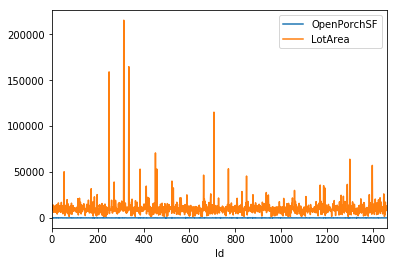

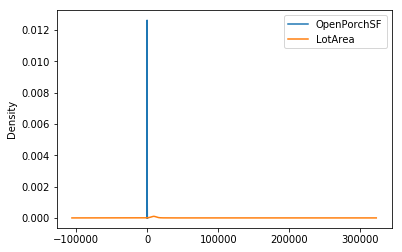

In [33]:
%matplotlib inline
# 尺度沒有調整前
X_full[['OpenPorchSF', 'LotArea']].plot()
X_full[['OpenPorchSF', 'LotArea']].plot.kde()

C:\RnD\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


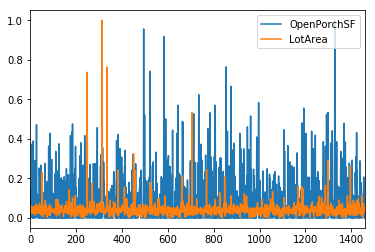

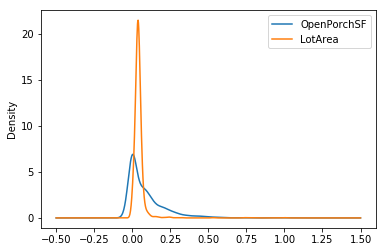

In [34]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
mm_X = pd.DataFrame(mm_scaler.fit_transform(X_full[['OpenPorchSF', 'LotArea']]), columns=X_full[['OpenPorchSF', 'LotArea']].columns)
# MinMax 正規化
mm_X.plot()
mm_X.plot.kde()

C:\RnD\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\RnD\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


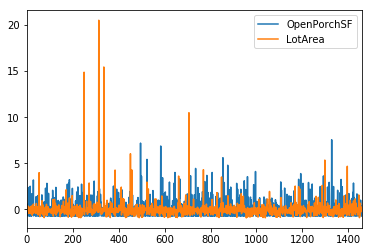

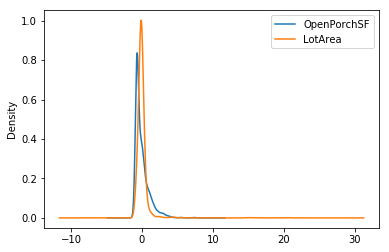

In [35]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_X = pd.DataFrame(std_scaler.fit_transform(X_full[['OpenPorchSF', 'LotArea']]), columns=X_full[['OpenPorchSF', 'LotArea']].columns)
# 標準化後
std_X.plot()
std_X.plot.kde()

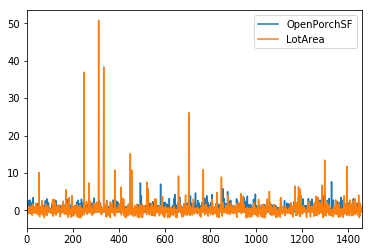

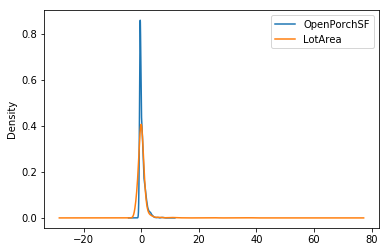

In [36]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()
rob_X = pd.DataFrame(rob_scaler.fit_transform(X_full[['OpenPorchSF', 'LotArea']]), columns=X_full[['OpenPorchSF', 'LotArea']].columns)
# 標準化後
rob_X.plot()
rob_X.plot.kde()

### Min-Max Rescale

有時可能有特殊需求，scikit-learn 現成的正規化函式不敷使用。 但是正規化的處理不是太複雜，自己寫也不難。 以下兩個函式範例供參考，一個是 numpy.ndarray 輸入的版本，一個是 pd.Series 輸入的版本。

In [ ]:
def minmax_rescale_array(data):
    """根據 data 的最大最小值，重新調整所有 data 元素尺度到 [0,1] 區間。
        [參數]：
            data - np.ndarray 數值資料陣列
    """
    amin, amax = np.amin(data), np.amax(data)
    
    if amin == amax:
        # add a smallest epsilon float value to prevent from divide-by-zero error
        amax += np.finfo(float).eps
    return (data - amin) / (amax - amin)

In [ ]:
def minmax_rescale_series(data, range):
    '''按照事先定義的 range 範圍,重新調整欄位尺度到 [0,1] 區間。
        超過定義範圍的欄位值會強制截去超過的部分。

        [參數]：
            data - pandas.Series 類型
            range - (min, max) tuple，分別定義欄位的最小值及最大值。
                    (None, None) 會由 data 中取最大值和最小值。
        [返回]：
            尺度調整後的 Series 複本。
    '''
    data2scale = data.copy()
    minval = range[0] if range[0] != None else data2scale.min()
    maxval = range[1] if range[1] != None else data2scale.max()
    # clipping those out of range values
    data2scale.where(col2scale >= minval, minval, inplace=True)
    data2scale.where(col2scale <= maxval, maxval, inplace=True)
    return (data2scale - minval) / (maxval - minval)

<a id="references"></a>

## References:

+ Dan Becker, *"Intermediate Machine Learning"*, Kaggle, 2019. [[link]](https://www.kaggle.com/learn/intermediate-machine-learning)